<a href="https://colab.research.google.com/github/daayvm/DiplomadoCD/blob/main/examen_velasco_martell_dayra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Módulo III - Examen - Velasco Martell Dayra

**Análisis de preguntas de usuarios en un sistema de ayuda**

**Contexto**

Se cuenta con un conjunto de datos compuesto por preguntas reales que los usuarios realizaron a una pantalla de ayuda durante la ejecución de un proceso. Cada registro incluye el texto de la pregunta y una representación vectorial (embeddings).

El objetivo del examen es analizar, preparar y modelar estos datos mediante técnicas de aprendizaje no supervisado, con el fin de identificar patrones, temas recurrentes y agrupaciones relevantes.

Bibliotecas

In [2]:
# Install missing libraries


!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 7.8 MB/s eta 0:00:00


In [38]:
#Archivos desde mi drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import ast

#Reducción de dimensiones
from sklearn.decomposition import PCA

# Visualización

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Carga de datos**

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Diplomado/dataset_examen.csv")
df

,pregunta,embedding
0,Por qué no puedo continuar,"[-0.03749788925051689, -0.02944916859269142, -..."
1,Un préstamo personal,"[-0.02106071636080742, -0.026762235909700394, ..."
2,"Quiero que la nómina llegue directo, no quiero...","[-0.04777172952890396, -0.013125989586114883, ..."
3,Domicilio central campesina independiente 1315...,"[-0.009193808771669865, 0.02650371566414833, -..."
4,Si. Osio. O. No,"[-0.012685798108577728, -0.021515648812055588,..."
...,...,...
4995,Como me fijo en tu banca en linea,"[-0.02022521197795868, -0.01131681352853775, 0..."
4996,Pues ver los beneficios,"[-0.014605613425374031, -0.022445684298872948,..."
4997,Le mando el ine,"[-0.02759142965078354, -0.017689231783151627, ..."
4998,Como saber si fui aprovada para credito,"[-0.005574708804488182, 0.0022197223734110594,..."


**Calidad de los datos**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pregunta   5000 non-null   object
 1   embedding  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


Descripción breve de variables

* pregunta: Consultas de usuarios en un sistema de ayuda

* embedding: Representa el significado semántico de la pregunta

Revisión de duplicados

In [10]:
df.duplicated(subset="pregunta").sum()

np.int64(337)

Se eliminan preguntas duplicadas para evitar sesgo en el clustering

In [11]:
df = df.drop_duplicates(subset="pregunta").reset_index(drop=True)
df.shape

(4663, 3)

Longitud del texto

In [8]:
df["len"] = df["pregunta"].astype(str).str.len()
df["len"].describe()

,len
count,5000.000000
mean,33.236800
std,29.349511
min,8.000000
25%,18.000000
50%,26.000000
75%,40.000000
max,554.000000


Revisar textos vacíos o solo espacios dentro de la variable pregunta

In [12]:
(df["pregunta"].astype(str).str.strip() == "").sum()

np.int64(0)

No se identificaron valores nulos ni textos vacíos. La calidad estructural de los datos es adecuada para el modelado.

Se revisan caracteres raros o posible ruido

In [13]:
df["pregunta"].sample(15, random_state=42)

,pregunta
2759,Pero como le puedo hacer para tener una tarjeta
1849,Porque ya había enviado mi nombre mi primer ap...
2277,Yo necesito un prestamo no quiero cambiar mi n...
23,No entiendo solo que mi nómina la tengo en Ban...
1175,Trabajo por mi cuenta
1992,Gracias y que tengas buen día
1255,"Quiero un préstamo de 12,000.00"
2770,"Necesito $50,000 para mi negocio"
3442,Para cobrar
501,No tengo esa tarjeta


Se identificaron algunas frases cortas o poco informativas, pero representan interacciones reales del sistema, por lo que se mantuvieron para el análisis

Revisión de outliers

In [14]:
df.sort_values("len", ascending=False).head(5)[["pregunta","len"]]

,pregunta,len
3203,Solo quiero saber si se me va a dar el préstam...,554
2778,Esq yo tengo 3 años con BBwV i tengo mi tarjet...,440
1309,Yo trabajé de 1999 91 pero entonces he trabaja...,417
2910,Buenos dias mi acesor de esta estetucion estue...,388
3789,Nomas k me dijeran sime pueden prestar el dine...,330


Se revisaron posibles outliers en la variable pregunta mediante el análisis de longitud del texto e inspección manual. Se identificaron algunas preguntas extensas, estas corresponden a consultas reales y no representan ruido o errores, por lo que no se eliminaron registros por este criterio.

**Emedings**

Los embeddings fueron transformados de formato texto a vectores numéricos para permitir el cálculo de distancias y la aplicación de métodos de modelación no supervisada

In [17]:
# Convertir string a lista real
df["embedding"] = df["embedding"].apply(ast.literal_eval)

# Convertir a matriz
X = np.vstack(df["embedding"].values)
X.shape

(4663, 1536)

**Reducción de dimensiones**

In [22]:
#Aplicamos PCA
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X)

X_reduced.shape

(4663, 100)

In [21]:
#Varianza
explained_variance = pca.explained_variance_ratio_.sum()
explained_variance

np.float64(0.6265793720976804)

Se aplicó PCA para reducir la dimensionalidad de 1536 a 100 componentes, conservando aproximadamente el 62.7% de la varianza total.

Esta reducción permite disminuir la complejidad computacional y el ruido, manteniendo una proporción significativa de la información necesaria para el clustering

Visualización de tres componentes

In [23]:
pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X)

X_3d.shape

(4663, 3)

In [29]:
fig = px.scatter_3d(
    df_3d,
    x="PC1",
    y="PC2",
    z="PC3",
    title="Distribución de preguntas",
    color_discrete_sequence=["#3A86FF"]
)

fig.update_traces(marker=dict(size=3, opacity=0.6))

fig.show()

Se realizó una reducción a tres componentes principales únicamente con fines exploratorios. La visualización permite observar la distribución general de las preguntas, aunque la separación de grupos no es completamente evidente a simple vista

**Número de clusters óptimo**

CODO

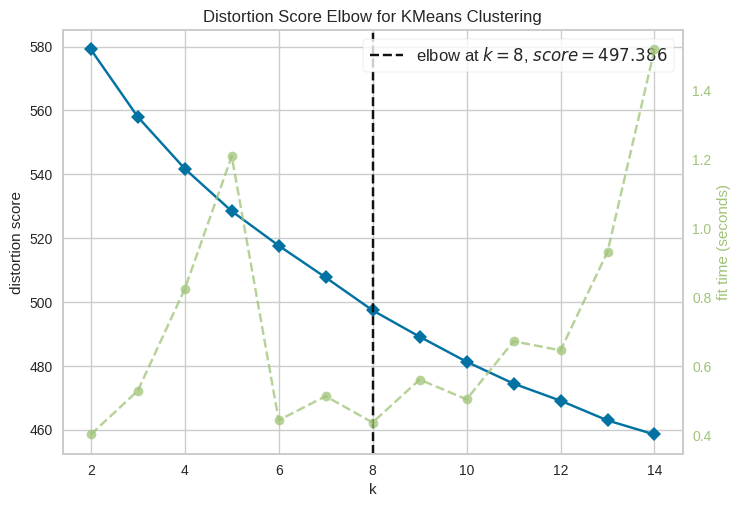

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
model = KMeans(init="k-means++", max_iter=300, n_init=10, random_state=42)

visualizer = KElbowVisualizer(
    model,
    k=(2,15),
    colors="blue"
)

visualizer.fit(X_reduced)
visualizer.show()

SILUETA

In [36]:
silueta = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silueta.append(score)

df_silueta = pd.DataFrame({
    "N_Clusters": range(2, 11),
    "Score": silueta
})

fig = px.line(
    df_silueta,
    x="N_Clusters",
    y="Score",
    markers=True,
    title="Número de clusters",
    color_discrete_sequence=["#1f77b4"]
)

fig.update_traces(line=dict(width=3))
fig.update_layout(template="plotly_white")

fig.show()


El método del codo sugiere un punto de inflexión en **K = 8**, indicando rendimientos decrecientes al incrementar el número de clusters.

La métrica de silueta presenta valores bajos y su máximo dentro del rango evaluado se observa en **K = 10**, lo que sugiere una separación ligeramente mejor con más grupos.

Se selecciona **K = 8** como solución final por balance entre calidad y simplicidad interpretativa, manteniendo K=10 como alternativa de sensibilidad

**Clustering**

KMEANS

In [37]:
# Definimos K final (según codo)
k_final = 8

km = KMeans(
    n_clusters=k_final,
    init="k-means++",
    random_state=42,
    n_init=10
)
df["cluster"] = km.fit_predict(X_reduced)

df["cluster"].value_counts().sort_index()

,count
cluster,
0,656
1,261
2,769
3,1458
4,410
5,405
6,284
7,420


GMM

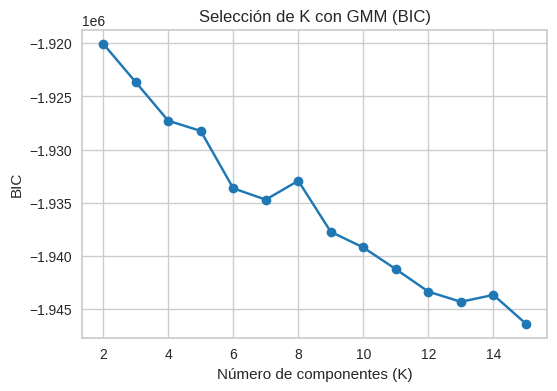

In [39]:
K_range = range(2, 16)
bics = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type="diag", random_state=42)
    gmm.fit(X_reduced)
    bics.append(gmm.bic(X_reduced))

plt.figure(figsize=(6,4))
plt.plot(list(K_range), bics, marker="o", color="#1f77b4")
plt.xlabel("Número de componentes (K)")
plt.ylabel("BIC")
plt.title("Selección de K con GMM (BIC)")
plt.show()


In [40]:
k_gmm = 8

gmm = GaussianMixture(n_components=k_gmm, covariance_type="diag", random_state=42)
df["cluster_gmm"] = gmm.fit_predict(X_reduced)

df["cluster_gmm"].value_counts().sort_index()


,count
cluster_gmm,
0,410
1,727
2,284
3,365
4,649
5,276
6,1830
7,122


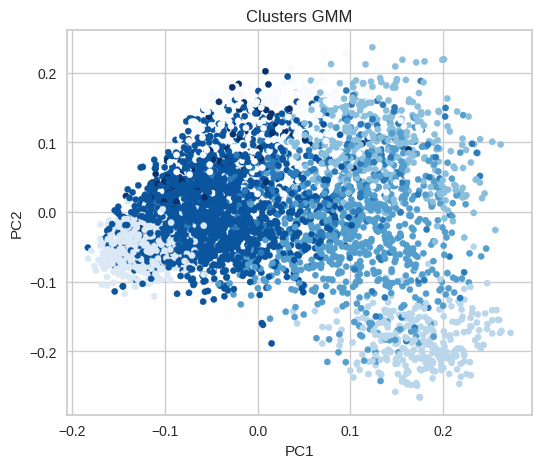

In [43]:
plt.figure(figsize=(6,5))
plt.scatter(
    X_3d[:,0],
    X_3d[:,1],
    c=df["cluster_gmm"],
    cmap="Blues",
    s=20
)
plt.title("Clusters GMM")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Se evaluaron distintos enfoques de clustering, incluyendo K-Means y Gaussian Mixture Models. En GMM sugiere que un mayor número de componentes mejora el ajuste, esto puede conducir a una sobre-segmentación en espacios semánticos complejos.

Considerando el equilibrio entre calidad, estabilidad e interpretabilidad, se seleccionó **K-Means con K = 8** como modelo final.

**Perfilamiento de clusters por temas**

Cluster 0

In [44]:
df[df["cluster"] == 0][["pregunta"]].sample(10, random_state=42)

,pregunta
1345,Xq no me llega el dinero q Gano o Los puntos
1861,aque banco puedoir
674,Cómo serían los pagos
4424,Es que lo necesito por qué tengo que pagar ren...
3631,No me pagan en efectivo
917,Ke puedo hacer para recibir
1662,Si ya está mi nombre en el banco todo perfecto
1823,Pero disculpa acaso tengo dinero en el banco
482,Ycuanto tienpo puedoretirarlo cuantotengo enmi...
1541,Puedo pagar


Titulo: Gestión de pagos y disponibilidad de dinero

Descripción: Consultas sobre pagos, recepción de dinero, tiempos de depósito y retiro

Cluster 1

In [45]:
df[df["cluster"] == 1][["pregunta"]].sample(10, random_state=42)

,pregunta
561,Ok gracias iré personalmente AMI sucursal ya q...
2693,Beneficios protección con tu bendita presencia...
3078,Muchas gracias excelente día
1601,Bueno días
2965,Estoy bien agradecido gracias
4590,Buena noche
3456,Muchas gracias me llamo Fernando Higinio copad...
1907,Igualmente exelente noche
195,No grasias
3367,Hahahahaha OK esta muy bien


Titulo: Mensajes de cortesía y agradecimiento

Descripción: Interacciones sociales como saludos, agradecimientos y cierre de conversación

Cluster 2

In [46]:
df[df["cluster"] == 2][["pregunta"]].sample(10, random_state=42)

,pregunta
4077,K es el número INE
1875,Q procede aora ya di todos mis datos
3786,Tengo todos mis documentos actualizados
4182,En mi correo la primera letra es R mayúscula y...
2843,Esa es mi identificación
1196,Pues tengo vencida mi credencial
643,Me piden mi correo electrónico pero nose cuál ws
1958,Hola si tengo mi credencial de INE
3444,En un momento por que ando en un mandado y mi ...
874,Cuando llega el correo y que debe de decir?


Titulo: Validación de identidad y documentos

Descripción: Preguntas sobre INE, credenciales, correo electrónico y actualización de datos personales

Cluster 3

In [47]:
df[df["cluster"] == 3][["pregunta"]].sample(10, random_state=42)

,pregunta
4248,Mucho mejor
2703,Estoy de acuerdo
1391,Está ien
1736,Cómo puedo yo aserle
3384,Pues ya me a pasado
2039,Kierokenami. Me ayudes
728,YA MEPUEDES ACTUALISAR LA CAMRA PARA TOMAR LAS...
3376,Quiero consultar
4142,Donde puedo aser eso
2881,Noentiendo comoyen


Titulo: Soporte general y dudas abiertas

Descripción: Solicitudes de ayuda y preguntas poco específicas sobre el uso del sistema.

Cluster 4

In [48]:
df[df["cluster"] == 4][["pregunta"]].sample(10, random_state=42)

,pregunta
2108,Puedo otra tarjeta
1570,Quiero mi tarjeta
1407,Cómo leago. Para saber. Demi. Tarjeta. De cred...
1110,No tengo esa tarjeta el lunes la saco gracias
900,Necesito una tarjeta de credito
501,No tengo esa tarjeta
4244,Le estoy diciendo que mi tarjeta está vigente ...
2681,Bueno estoh buscando una tarjeta de credito
3627,No me se mi cuenta de tarjeta si la tengo pero...
2709,Este trámite es para tener una tarjeta de débito?


Titulo: Tarjetas bancarias

Descripción: Solicitudes y consultas relacionadas con tarjetas de crédito y débito

Cluster 5

In [49]:
df[df["cluster"] == 5][["pregunta"]].sample(10, random_state=42)

,pregunta
752,Cuando me yega el prestamo
2448,Me podría apoyar con mi prestamo
4446,un prestamo
432,Hola quiero un préstamo
498,Si me van a dar el préstamo que se deposite en...
912,Sii de cuánto sería mi préstamo sies kemelo au...
1533,En poder saber en cuál cuenta está mi prestamo
3831,Quiero una prestamoa
4277,Cuanto me prestan
3048,Disculpe pero entonses ustedes no m pueden lib...


Titulo: Préstamos

Descripción: Solicitudes, montos, aprobación y seguimiento de préstamos.

Cluster 6

In [51]:
df[df["cluster"] == 6][["pregunta"]].sample(10, random_state=42)

,pregunta
165,No tengo nomina hace mucho q no trabajo por es...
4104,"No estoy en nómina, trabajo independiente"
2533,Pues no cuento con una cuenta de nomina pues m...
3387,Crédito de nomina preparado
1177,No tengo Nomina
3790,Con la portabilidad de nómina x favor
4270,No tengo nomina yo soy comerciante
2722,Cómo crear una cuenta de nomina
658,Crédito de nómina
3640,Necesito saber de mi nomina


Titulo: Información y requisitos relacionados con nómina

Descripción: Los usuarios consultan sobre requisitos, creación de cuentas de nómina, elegibilidad y situaciones en las que no cuentan con ingresos formales.

Cluster 7

In [50]:
df[df["cluster"] == 7][["pregunta"]].sample(10, random_state=42)

,pregunta
1545,10dias abiles
3539,Jesús Manuel Leal valdez
1838,Filiberto palmeros montero 22÷08÷62 hombre
4049,Mi ine esta vigente mi licemcia mi gaffrte yo ...
4623,Yolñtenno
657,SOY DE NUEVA ROSITA COAHUILA...SI NESECITAS MA...
1370,Comosedelats
1443,Maria de Guadalupe Alvarado Martínez
236,Josué conde sanchez
651,5 de Marzo de 1959


Titulo: Datos personales y captura de información

Descripción: Registros que contienen nombres, fechas y datos de identificación